In [1]:
# pip install git+https://github.com/5121eun/dl

  Cloning https://github.com/5121eun/dl to /tmp/pip-req-build-fj6uguet
  Running command git clone --filter=blob:none --quiet https://github.com/5121eun/dl /tmp/pip-req-build-fj6uguet
  Resolved https://github.com/5121eun/dl to commit b44d5848e166ab270fcf0c4579c2ac68161b06bb
  Preparing metadata (setup.py) ... done
  Created wheel for dl: filename=dl-0.1.6-py3-none-any.whl size=10088 sha256=635ec74af1b5b7cf74eaee32a883afc72b024d4a9f5bae2c6d3872d8f805e91a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlq7l8wm/wheels/2b/98/11/a0a860dd39665dde2761acac48a1a9b16fb7ffd9c02a483880
Successfully built dl
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 9.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import Tensor
from torch import nn
from torchvision.models import resnet50
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.patches as patches
import matplotlib.pyplot as plt

from commons.utils import cxcywh_to_xywh
from models.detr import *

import numpy as np

import cv2
import os
import xml.etree.ElementTree as et

from scipy.optimize import linear_sum_assignment

import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_dir = "/kaggle/input/fruit-images-for-object-detection/train_zip/train"
test_dir = "/kaggle/input/fruit-images-for-object-detection/test_zip/test"

In [5]:
class FruitDataSet(Dataset):
    def __init__(self, file_dir: str, c_list: list, transform=None):
        
        self.dir = file_dir
        self.imgs = [img[:-4] for img in sorted(os.listdir(file_dir))
                        if img[-4:]=='.jpg']
        
        self.c_list = c_list
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        
        img_name = self.imgs[idx]
        img = plt.imread(f"{self.dir}/{img_name}.jpg")[:, :, :3]
        
        tree = et.parse(f"{self.dir}/{img_name}.xml")
        root = tree.getroot()

        img_h = img.shape[0]
        img_w = img.shape[1]

        cs = []
        bboxes = []
        for obj in root.findall('object'):
            c = self.c_list.index((obj.find('name').text))
            x1 = (float(obj.find('bndbox').find('xmin').text) / img_w)
            x2 = (float(obj.find('bndbox').find('xmax').text) / img_w) 
            y1 = (float(obj.find('bndbox').find('ymin').text) / img_h)
            y2 = (float(obj.find('bndbox').find('ymax').text) / img_h)
            w = x2 - x1
            h = y2 - y1
            cs.append(c)
            bboxes.append([x1 + (w / 2), y1 + (h / 2), w, h])
        
        tgt = {}
        tgt['bboxes'] = bboxes
        tgt['c'] = cs
        tgt['size'] = (img_h, img_w)
        
        if self.transform:
            img = self.transform(img)
        
        return img, tgt

In [6]:
def sqrd_pdding(img):
    if img.shape[0] > img.shape[1]:
        max_size = img.shape[0]
    else:
        max_size = img.shape[1]
        
    return transforms.Pad(padding=((max_size - img.shape[2])//2, (max_size - img.shape[1])//2, (max_size - img.shape[2])//2, (max_size - img.shape[1])//2))(img)

In [7]:
def collate_padding_fn(samples):
    imgs = [sample[0] for sample in samples]
    tgts = [sample[1] for sample in samples]
    for i in range(len(samples)):
        tgts[i]['bboxes'] = torch.tensor(tgts[i]['bboxes'] + bboxes_pad * (n_query - len(tgts[i]['bboxes'])))
        tgts[i]['c'] = tgts[i]['c'] + [no_obj_c for _ in range(n_query - len(tgts[i]['c']))]

    return (torch.stack(imgs).contiguous(), tgts)

In [8]:
def show(logits, bboxes):
    logits, bboxes = logits.cpu(), bboxes.cpu()
    
    fig_size = 10
    box_color = 'aqua'
    tg_box_color = 'red'
    text_color = 'black'

    fig = plt.figure(figsize=(fig_size, fig_size))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(img[i].permute(1, 2, 0))

        for j in range(n_query):
            bbox = bboxes[i][j].detach()* np.array([img_size, img_size, img_size, img_size])
            bbox = cxcywh_to_xyxy(bbox) 
            tg_bbox = tgt[i]['bboxes'][j] * np.array([img_size, img_size, img_size, img_size])
            tg_bbox = cxcywh_to_xyxy(tg_bbox)
            c = c_list[logits[i][j].argmax(-1)]
            tg_c = c_list[tgt[i]['c'][j]]
            if c != None:
                ax.text(bbox[0], bbox[1], c, 
                     color=text_color, 
                     backgroundcolor=(box_color),
                     fontsize='small')
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                    edgecolor=(box_color),
                    linewidth=2, 
                    fill=True,
                    alpha =0.3 )

                ax.add_patch(rect)

            if tg_c != None:
                tg_rect = patches.Rectangle((tg_bbox[0], tg_bbox[1]), tg_bbox[2] - tg_bbox[0], tg_bbox[3] - tg_bbox[1], 
                edgecolor=tg_box_color,
                linewidth=2, 
                fill=False,
                alpha = 1)

#                 ax.add_patch(tg_rect)


    plt.setp(ax, xticks=[], yticks=[])
    fig.set_facecolor('black')
    plt.subplots_adjust(wspace=0, hspace=0)

In [9]:
batch_size = 32

img_size = 224

n_cls = 3
no_obj_c = 3
c_list = ['apple', 'banana', 'orange', None]
bboxes_pad = [[0, 0, 0, 0]]

dim = 256
nheads = 8
enc_depth = 6
dec_depth = 6

n_query = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

lr = 2e-4

cuda


In [10]:
padding = transforms.Lambda(lambda y:
    sqrd_pdding(y)
)

transform = transforms.Compose([
    transforms.ToTensor(),
    padding,
    transforms.Resize((img_size, img_size), antialias=True),
])

In [11]:
dataset = FruitDataSet(train_dir, c_list, transform)
test_dataset = FruitDataSet(test_dir, c_list, transform)

In [12]:
loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_padding_fn)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_padding_fn)

In [13]:
from torchvision.models import resnet50
backbone = nn.Sequential(*list(resnet50(weights='ResNet50_Weights.DEFAULT').children())[:-2])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s] 


In [14]:
model = DETR(backbone, 2048, n_cls, 100, n_query, dim, nheads, enc_depth, dec_depth).to(device)
model_opt = torch.optim.AdamW(model.parameters(), lr=lr)

loss_fn = DETRLoss(n_query, 2, 5, ls_giou_w=20).to(device)

In [15]:
for i in range(500):
    for img, tgt in loader:
        logits, bboxes = model(img.to(device))
    
        idx = torch.tensor([tgt[b]['c'] for b in range(len(tgt))])
        gt_b = torch.stack([tgt[b]['bboxes'] for b in range(len(tgt))], 0)
        
        ls = loss_fn(idx.to(device), logits, gt_b.to(device), bboxes, 3, 100).sum(-1).mean()

        model_opt.zero_grad()
        ls.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        model_opt.step()
        
    print(f"{i}: {ls} ")

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


0: 131.61448669433594 
1: 148.69775390625 
2: 110.89937591552734 
3: 86.46173858642578 
4: 77.13351440429688 
5: 82.03582763671875 
6: 87.77421569824219 
7: 68.8162612915039 
8: 66.56485748291016 
9: 63.46493148803711 
10: 72.29255676269531 
11: 64.94296264648438 
12: 54.75001525878906 
13: 58.74385070800781 
14: 64.70405578613281 
15: 55.680355072021484 
16: 62.55928039550781 
17: 60.277626037597656 
18: 60.15011978149414 
19: 59.52188491821289 
20: 65.1888427734375 
21: 59.307498931884766 
22: 67.19723510742188 
23: 56.18115234375 
24: 51.473026275634766 
25: 55.506385803222656 
26: 63.74030685424805 
27: 56.1468620300293 
28: 53.78077697753906 
29: 46.35624313354492 
30: 51.3327751159668 
31: 56.53239440917969 
32: 56.68063735961914 
33: 47.49134826660156 
34: 54.160362243652344 
35: 54.05805206298828 
36: 49.47723388671875 
37: 50.99503707885742 
38: 50.263038635253906 
39: 62.11675262451172 
40: 46.52659606933594 
41: 49.052162170410156 
42: 48.290611267089844 
43: 52.409683227539

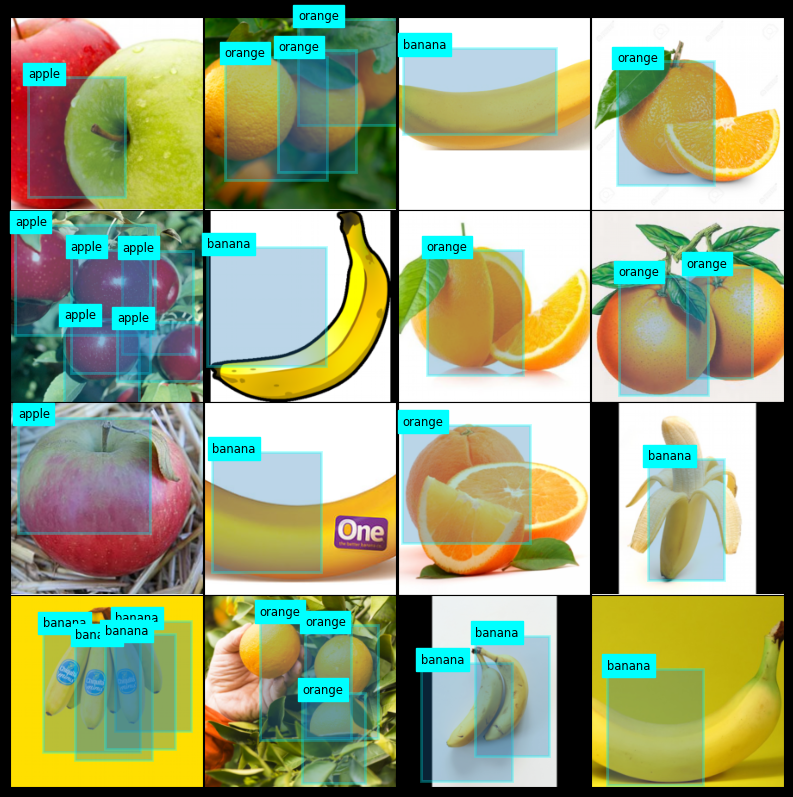

In [16]:
show(logits, bboxes)